In [1]:
#!unzip data.zip

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.svm import SVC 
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import KNeighborsClassifier
import xgboost

In [3]:
dfTrain = pd.read_csv("Health Insurance Cross Sell Prediction/data/train.csv")
dfTest = pd.read_csv("Health Insurance Cross Sell Prediction/data/test.csv")

In [4]:
df = pd.concat([dfTrain, dfTest], axis=0)

df

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1.0
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0.0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1.0
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0.0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
127032,508142,Female,26,1,37.0,1,< 1 Year,No,30867.0,152.0,56,NaN
127033,508143,Female,38,1,28.0,0,1-2 Year,Yes,28700.0,122.0,165,NaN
127034,508144,Male,21,1,46.0,1,< 1 Year,No,29802.0,152.0,74,NaN
127035,508145,Male,71,1,28.0,1,1-2 Year,No,62875.0,26.0,265,NaN


In [5]:
# Check missing data

df.info()

# No missing data is detected

<class 'pandas.core.frame.DataFrame'>
Int64Index: 508146 entries, 0 to 127036
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    508146 non-null  int64  
 1   Gender                508146 non-null  object 
 2   Age                   508146 non-null  int64  
 3   Driving_License       508146 non-null  int64  
 4   Region_Code           508146 non-null  float64
 5   Previously_Insured    508146 non-null  int64  
 6   Vehicle_Age           508146 non-null  object 
 7   Vehicle_Damage        508146 non-null  object 
 8   Annual_Premium        508146 non-null  float64
 9   Policy_Sales_Channel  508146 non-null  float64
 10  Vintage               508146 non-null  int64  
 11  Response              381109 non-null  float64
dtypes: float64(4), int64(5), object(3)
memory usage: 50.4+ MB


**Correlation plot**

<AxesSubplot:>

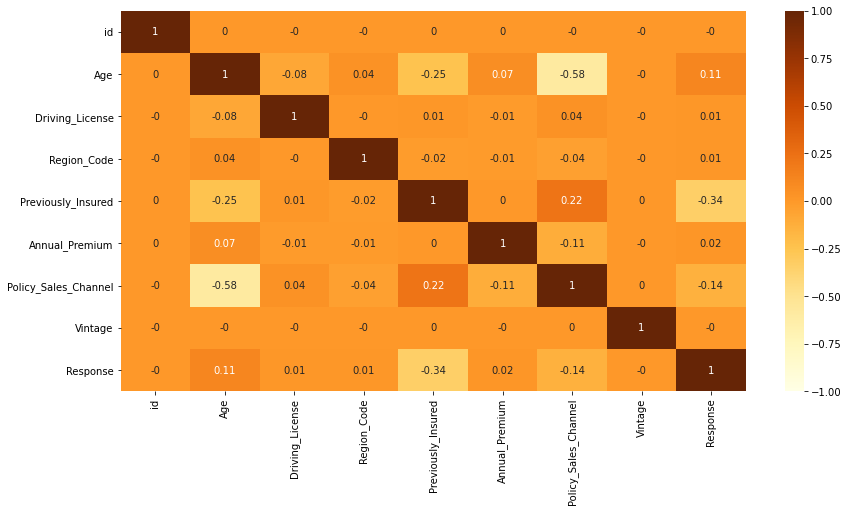

In [6]:
fig, ax = plt.subplots(figsize = (14,7))
corr = dfTrain.corr().round(2)
sns.heatmap(corr, annot = True, ax=ax, vmin=-1, vmax=1, center=0, cmap='YlOrBr')

# We observe that previously_insured is a relatively stronger correlated variable to Response
# Policy_Sales_Channel has a strong correlation with Age

**Check data skewness**

In [7]:
df.describe().transpose()

# Annual_Premium is right skewed

,count,mean,std,min,25%,50%,75%,max
id,508146.0,254073.500000,146689.259281,1.0,127037.25,254073.5,381109.75,508146.0
Age,508146.0,38.808413,15.500179,20.0,25.00,36.0,49.00,85.0
Driving_License,508146.0,0.997936,0.045388,0.0,1.00,1.0,1.00,1.0
Region_Code,508146.0,26.406572,13.224921,0.0,15.00,28.0,35.00,52.0
Previously_Insured,508146.0,0.458667,0.498289,0.0,0.00,0.0,1.00,1.0
Annual_Premium,508146.0,30554.453041,17146.574625,2630.0,24381.00,31661.0,39403.75,540165.0
Policy_Sales_Channel,508146.0,111.975838,54.246027,1.0,26.00,133.0,152.00,163.0
Vintage,508146.0,154.340123,83.668793,10.0,82.00,154.0,227.00,299.0
Response,381109.0,0.122563,0.327936,0.0,0.00,0.0,0.00,1.0


<AxesSubplot:xlabel='Response', ylabel='count'>

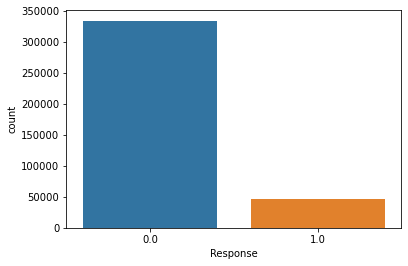

In [8]:
# Check Predictor: Response

sns.countplot(x= 'Response', data=df)

# Most of the participants do not want to purchase insurance

{'whiskers': [<matplotlib.lines.Line2D at 0x27e1ce7ccd0>,
 'caps': [<matplotlib.lines.Line2D at 0x27e1ce8d370>,
 'boxes': [<matplotlib.lines.Line2D at 0x27e1ce7ca00>],
 'medians': [<matplotlib.lines.Line2D at 0x27e1ce8d850>],
 'fliers': [<matplotlib.lines.Line2D at 0x27e1ce8db20>],
 'means': []}

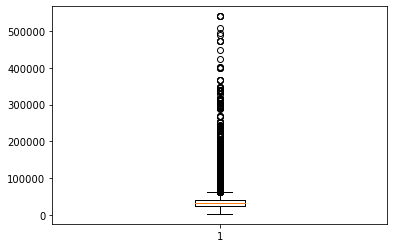

In [9]:
plt.boxplot(df.Annual_Premium)

In [10]:
# Define numeric and categorical variables

numeric_col = ['Age', 'Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']
cat_col = ['Driving_License', 'Previously_Insured', 'Vehicle_Age', 'Gender', 'Vehicle_Damage']


**Plot numerical columns**

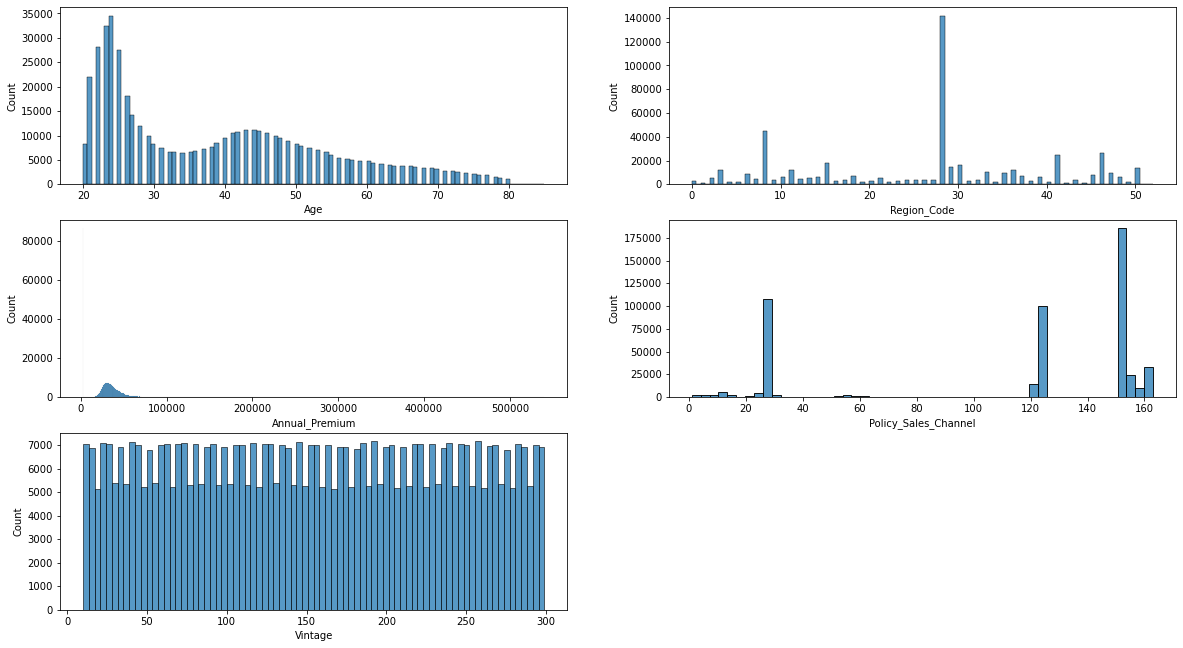

In [11]:
plt.figure(figsize=(20,15))
#sns.set(color_codes = True)

for i, col in enumerate(numeric_col):
    plt.subplot(4, 2, numeric_col.index(col)+1)
    sns.histplot(x= col, data=df)

# Age is right skewed
# Annual premium is right skewed

In [12]:
# Define categorical columns
# Label Encoding for categorical columns
for col in cat_col:
    le = LabelEncoder()
    df[col] = df[col].astype('category')
    df[col] = le.fit_transform(df[col])

**Plot categorical variables**

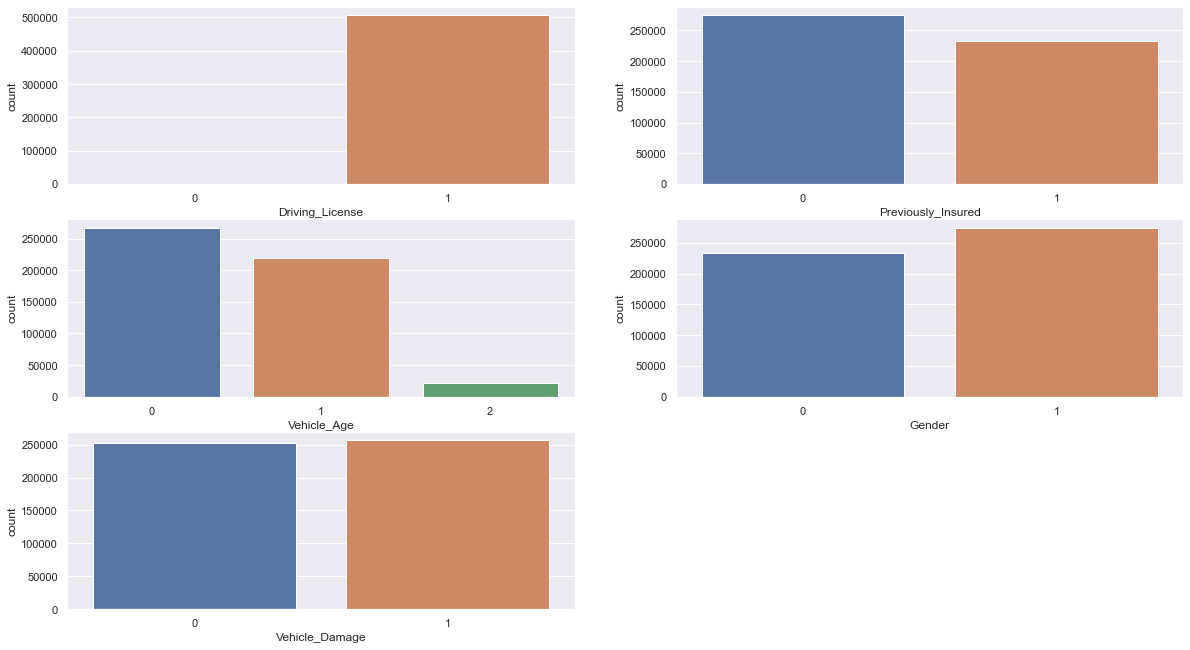

In [13]:
plt.figure(figsize=(20,15))
sns.set(color_codes = True)

for i, col in enumerate(cat_col):
    plt.subplot(4, 2, cat_col.index(col)+1)
    sns.countplot(x= col, data=df)

# Most of the participants have driving license

**Bivariate Analysis**

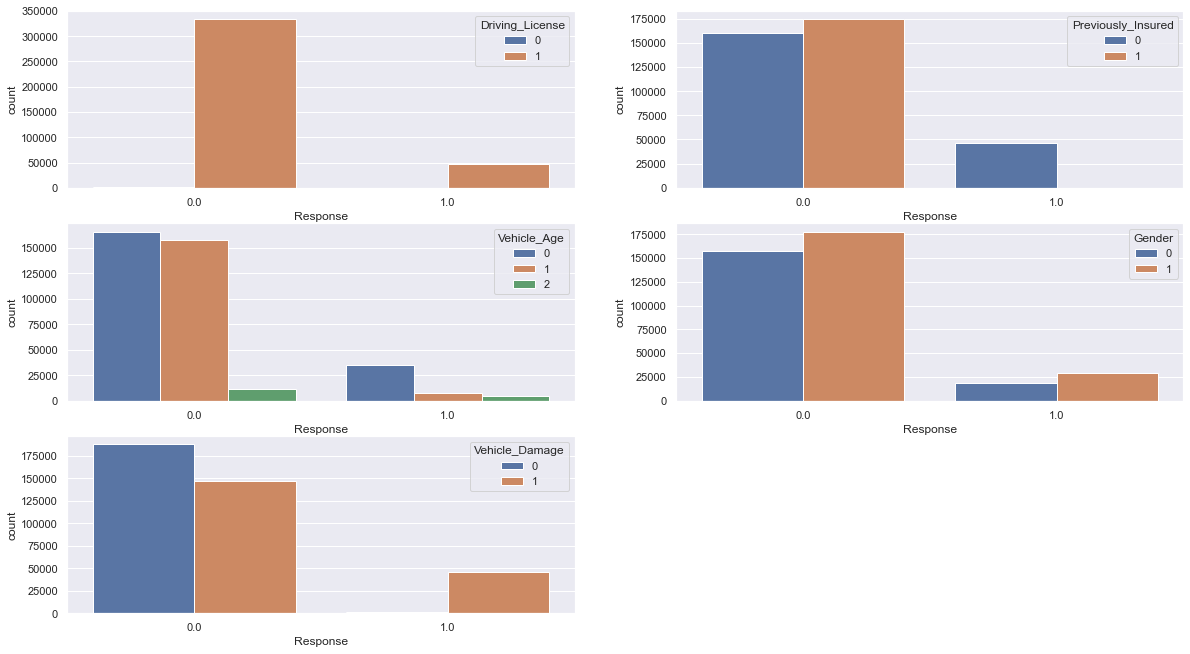

In [14]:
plt.figure(figsize=(20,15))

for i, col in enumerate(cat_col):
    plt.subplot(4, 2, cat_col.index(col)+1)
    sns.countplot(x= 'Response', hue =col, data=df)

# People who had vehicle damage are more likely to purchase insurance
# People who were not previously insured are more likely to purchase insurance

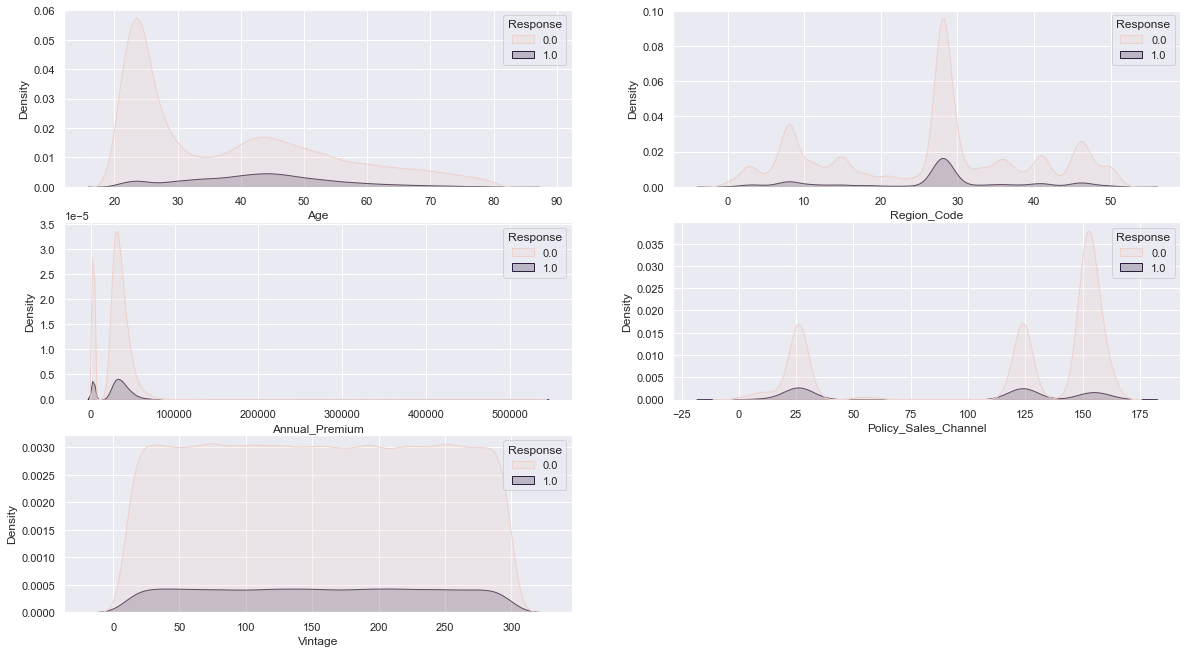

In [15]:
plt.figure(figsize=(20,15))

for i, col in enumerate(numeric_col):
    plt.subplot(4, 2, numeric_col.index(col)+1)
    sns.kdeplot(x= col, hue= 'Response', data=df, fill=True)

# Younger participants tend to reject insurance

In [16]:
# We can drop driving license column due to heavy skewness
df = df.drop(columns='Driving_License')

cat_col = ['Previously_Insured', 'Vehicle_Age', 'Gender', 'Vehicle_Damage']

In [17]:
# Split dataset to train and test set
dfTrain = df.iloc[0:381109,]
dfTest = df.iloc[381110:,]

# Define independent and dependent variables
Y = dfTrain['Response']
X = dfTrain.drop(['Response', 'id'], axis=1)

**Class Balancing**

In [18]:
ros = RandomOverSampler(random_state=0)

X, Y = ros.fit_resample(X, Y)

<AxesSubplot:xlabel='Response', ylabel='count'>

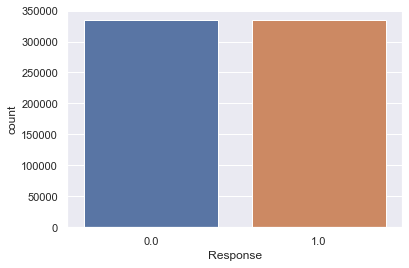

In [19]:
sns.countplot(x=Y)

In [20]:
# Normalizing numeric columns
for col in numeric_col:
    sc = StandardScaler()
    df[[col]] = sc.fit_transform(df[[col]])

In [21]:
# One hot encoding for categorical columns

df = pd.get_dummies(df, columns = cat_col)

In [22]:
# Reset index using id
#df.reset_index('id', inplace=True)
#df

In [23]:
# Train test split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=10, shuffle=True)

X_test = dfTest.drop(['Response', 'id'], axis=1)

X_test

,Gender,Age,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
1,1,40,28.0,0,0,1,33762.0,7.0,111
2,1,47,28.0,0,0,1,40050.0,124.0,199
3,1,24,27.0,1,1,1,37356.0,152.0,187
4,1,27,28.0,1,1,0,59097.0,152.0,297
5,1,22,30.0,1,1,0,40207.0,152.0,266
...,...,...,...,...,...,...,...,...,...
127032,0,26,37.0,1,1,0,30867.0,152.0,56
127033,0,38,28.0,0,0,1,28700.0,122.0,165
127034,1,21,46.0,1,1,0,29802.0,152.0,74
127035,1,71,28.0,1,0,0,62875.0,26.0,265


In [24]:
print("Size of X_train DataFrame: ", X_train.shape)
print("Size of X_val DataFrame: ", X_val.shape)
print("Size of X_test DataFrame: ", X_test.shape)

Size of X_train DataFrame:  (535038, 9)
Size of X_val DataFrame:  (133760, 9)
Size of X_test DataFrame:  (127036, 9)


## **Create Baseline Models**

### **Model 1: Logistic Regression**

In [25]:
log_clf = LogisticRegression(max_iter=2000)
log_clf.fit(X_train, Y_train)
Y_pred_log_val = log_clf.predict(X_val)
auc_log_val_base = roc_auc_score(Y_val, Y_pred_log_val) 

print("Baseline logistic regression model AUC score:", auc_log_val_base)

Baseline logistic regression model AUC score: 0.7772852555380961


### **Model 2: Random Forest Classifier**

In [26]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, Y_train)
Y_pred_rf_val = rf_clf.predict(X_val)
auc_rf_val_base = roc_auc_score(Y_val, Y_pred_rf_val)

print("Baseline Random Forest model AUC score:", auc_rf_val_base)

Baseline Random Forest model AUC score: 0.9488202737324476


### **Model 3: Gradient Boosting Classifier**

In [27]:
gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train, Y_train)
Y_pred_gb_val = gb_clf.predict(X_val)
auc_gb_val_base = roc_auc_score(Y_pred_gb_val, Y_val)

print("Baseline Gradient Boosting model AUC score:", auc_gb_val_base)

Baseline Gradient Boosting model AUC score: 0.8193361672151894


### **Model 4: K Nearest Neighbor (KNN) Classifier**

In [28]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, Y_train)
Y_pred_knn_val = knn_clf.predict(X_val)
auc_knn_val_base = roc_auc_score(Y_pred_knn_val, Y_val)

print("Baseline K Nearest Neighbor model AUC score:", auc_knn_val_base)

Baseline K Nearest Neighbor model AUC score: 0.8494137536565356


### **Model 5: XGBoost Classifier**

In [29]:
xgb_clf = xgboost.XGBClassifier()
xgb_clf.fit(X_train, Y_train)
Y_pred_xgb_val = xgb_clf.predict(X_val)
auc_xgb_val_base = roc_auc_score(Y_pred_xgb_val, Y_val)

print("Baseline XGBoost Classifier model AUC score:", auc_xgb_val_base)

Baseline XGBoost Classifier model AUC score: 0.8334065111798612


### **Model 6: ExtraTrees Classifier**



In [30]:
xt_clf = ExtraTreesClassifier()
xt_clf.fit(X_train, Y_train)
Y_pred_xt_val = xt_clf.predict(X_val)
auc_xt_val_base = roc_auc_score(Y_pred_xt_val, Y_val)

print("Baseline ExtraTrees Classifier model AUC score:", auc_xt_val_base)

Baseline ExtraTrees Classifier model AUC score: 0.9712393320715207


### **Model 7: AdaBoost Classifier**

In [31]:
ab_clf = AdaBoostClassifier()
ab_clf.fit(X_train, Y_train)
Y_pred_ab_val = ab_clf.predict(X_val)
auc_ab_val_base = roc_auc_score(Y_pred_ab_val, Y_val)

print("Baseline AdaBoost Classifier model AUC score:", auc_ab_val_base)

Baseline AdaBoost Classifier model AUC score: 0.8213143913247711


### **Model 8: VotingClassifier**

In [32]:
estimators = []
estimators.append(('RF', RandomForestClassifier()))
estimators.append(('XT', ExtraTreesClassifier()))

vt_clf = VotingClassifier(estimators = estimators, voting='soft')
vt_clf.fit(X_train, Y_train)
Y_pred_vt_val = vt_clf.predict(X_val)
auc_vt_val_base = roc_auc_score(Y_pred_vt_val, Y_val)

print("Baseline Voting Classifier model AUC score:", auc_vt_val_base)

Baseline Voting Classifier model AUC score: 0.9635401018243899


### **Base Models Conclusion**

In [33]:
base_models =['Logistic Regression', 'Random Forest Classifier', 'Gradient Boosting Classifier', 'KNN classifier', 'XGBoost Classifier', 'ExtraTrees Classifier', 'AdaBoost Classifier', 'VotingClassifier']
auc_val = [auc_log_val_base, auc_rf_val_base, auc_gb_val_base, auc_knn_val_base, auc_xgb_val_base, auc_xt_val_base, auc_ab_val_base, auc_vt_val_base]

base_models_auc_scores = pd.DataFrame({'Model': base_models, 'Val_Set_AUC': auc_val,})
base_models_auc_scores

# Random Forest Classifier, ExtraTrees Classifier, and Voting Classifier are the top 3. We will perform grid search for these three models.

,Model,Val_Set_AUC
0,Logistic Regression,0.777285
1,Random Forest Classifier,0.948820
2,Gradient Boosting Classifier,0.819336
3,KNN classifier,0.849414
4,XGBoost Classifier,0.833407
5,ExtraTrees Classifier,0.971239
6,AdaBoost Classifier,0.821314
7,VotingClassifier,0.963540


## **Grid Search**

### **Model 1: Random Forest Classifier**

In [34]:
rf_clf = RandomForestClassifier()

param = {'n_estimators': [100, 300, 500],
        'criterion': ['gini', 'entropy', 'log_loss'],
        'min_samples_split': [2, 3, 5],
        'min_samples_leaf': [1, 2, 3, 5]
        }

rf_clf_cv = GridSearchCV(rf_clf, param_grid = param, scoring = 'roc_auc', cv=5, verbose=2)
rf_clf_cv.fit(X_train, Y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.5min
[CV] END criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.5min
[CV] END criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.5min
[CV] END criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.5min
[CV] END criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.4min
[CV] END criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 4.7min
[CV] END criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 4.5min
[CV] END criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 4.2min
[CV] END criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 4.3min
[CV] END c

C:\Users\ychong4\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
180 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ychong4\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ychong4\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\Users\ychong4\Anaconda3\lib\site-packages\joblib\parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\ychong4\Anaconda3\lib\sit

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'min_samples_leaf': [1, 2, 3, 5],
                         'min_samples_split': [2, 3, 5],
                         'n_estimators': [100, 300, 500]},
             scoring='roc_auc', verbose=2)

In [35]:
rf_clf = RandomForestClassifier(**rf_clf_cv.best_params_)
rf_clf.fit(X_train, Y_train)
Y_pred_rf_train = rf_clf.predict(X_train)
Y_pred_rf_val = rf_clf.predict(X_val)

auc_rf_train = roc_auc_score(Y_train, Y_pred_rf_train) 
auc_rf_val = roc_auc_score(Y_val, Y_pred_rf_val)

print("AUC score for Random Forest training set: ", auc_rf_train)
print("AUC score for Random Forest validation set: ", auc_rf_val)

AUC score for Random Forest training set:  0.9999121551153758
AUC score for Random Forest validation set:  0.9488053202379229


### **Model 2: ExtraTrees Classifier**

In [36]:
xt_clf = ExtraTreesClassifier()

param = {'n_estimators': [100, 300, 500],
        'criterion': ['gini', 'entropy', 'log_loss'],
        'min_samples_split': [2, 3, 5],
        'min_samples_leaf': [1, 2, 3, 5]
        }

xt_clf_cv = GridSearchCV(xt_clf, param_grid = param, scoring = 'roc_auc', cv=5, verbose=2)
xt_clf_cv.fit(X_train, Y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  51.7s
[CV] END criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  54.7s
[CV] END criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  52.4s
[CV] END criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  52.1s
[CV] END criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  53.4s
[CV] END criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 2.6min
[CV] END criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 2.6min
[CV] END criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 2.5min
[CV] END criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 2.7min
[CV] END c

C:\Users\ychong4\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
180 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ychong4\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ychong4\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\Users\ychong4\Anaconda3\lib\site-packages\joblib\parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\ychong4\Anaconda3\lib\sit

GridSearchCV(cv=5, estimator=ExtraTreesClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'min_samples_leaf': [1, 2, 3, 5],
                         'min_samples_split': [2, 3, 5],
                         'n_estimators': [100, 300, 500]},
             scoring='roc_auc', verbose=2)

In [37]:
xt_clf = ExtraTreesClassifier(**xt_clf_cv.best_params_)

xt_clf.fit(X_train, Y_train)
Y_pred_xt_train = xt_clf.predict(X_train)
Y_pred_xt_val = xt_clf.predict(X_val)
auc_xt_train = roc_auc_score(Y_pred_xt_train, Y_train)
auc_xt_val = roc_auc_score(Y_pred_xt_val, Y_val)

print("AUC score for ExtraTrees Classifier training set: ", auc_xt_train)
print("AUC score for ExtraTrees Classifier validation set: ", auc_xt_val)

AUC score for ExtraTrees Classifier training set:  0.9999121718591162
AUC score for ExtraTrees Classifier validation set:  0.9713248187044216


## **Model 3: Voting Classifier**

In [38]:
vt_clf = VotingClassifier(estimators=estimators)

param = {    
        'voting': ['soft'],
        }

vt_clf_cv = GridSearchCV(vt_clf, param_grid = param, scoring = 'roc_auc', cv=5, verbose=2)
vt_clf_cv.fit(X_train, Y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ........................................voting=soft; total time= 2.4min
[CV] END ........................................voting=soft; total time= 2.4min
[CV] END ........................................voting=soft; total time= 2.5min
[CV] END ........................................voting=soft; total time= 2.4min
[CV] END ........................................voting=soft; total time= 2.4min


GridSearchCV(cv=5,
             estimator=VotingClassifier(estimators=[('RF',
                                                     RandomForestClassifier()),
                                                    ('XT',
                                                     ExtraTreesClassifier())]),
             param_grid={'voting': ['soft']}, scoring='roc_auc', verbose=2)

In [39]:
vt_clf = VotingClassifier(estimators=estimators, **vt_clf_cv.best_params_)

vt_clf.fit(X_train, Y_train)
Y_pred_vt_train = vt_clf.predict(X_train)
Y_pred_vt_val = vt_clf.predict(X_val)
auc_vt_train = roc_auc_score(Y_pred_vt_train, Y_train)
auc_vt_val = roc_auc_score(Y_pred_vt_val, Y_val)

print("AUC score for Voting Classifier training set: ", auc_vt_train)
print("AUC score for Voting Classifier validation set: ", auc_vt_val)

AUC score for Voting Classifier training set:  0.9999121718591162
AUC score for Voting Classifier validation set:  0.9636539341542348


## **Selecting Model With Highest Accuracy**

In [44]:
models =['Random Forest Classifier', 'ExtraTrees Classifier', 'Voting Classifier']
auc_train = [auc_rf_train, auc_xt_train, auc_vt_train]
auc_val = [auc_rf_val, auc_xt_val, auc_vt_val]

models_cv_scores = pd.DataFrame({'Model': models, 'Train_Set_AUC': auc_train, 'Val_Set_AUC': auc_val,})
models_cv_scores

,Model,Train_Set_AUC,Val_Set_AUC
0,Random Forest Classifier,0.999912,0.948805
1,ExtraTrees Classifier,0.999912,0.971325
2,Voting Classifier,0.999912,0.963654


In [45]:
auc_max = models_cv_scores['Val_Set_AUC'].max()
idx = models_cv_scores['Val_Set_AUC'].idxmax()
model_max = models_cv_scores.iloc[idx,0]

print("The best model is: ", model_max, ", with an AUC score of", auc_max)

The best model is:  ExtraTrees Classifier , with an AUC score of 0.9713248187044216


In [46]:
if model_max == 'Random Forest Classifier':
    y_pred = rf_clf.predict(X_test)
elif model_max == 'ExtraTrees Classifier':
    y_pred = xt_clf.predict(X_test)
elif model_max == 'Voting Classifier':
    y_pred = vt_clf.predict(X_test)

dfTest['Response'] = y_pred

In [47]:
dfTest

,id,Gender,Age,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
1,381111,1,40,28.0,0,0,1,33762.0,7.0,111,1.0
2,381112,1,47,28.0,0,0,1,40050.0,124.0,199,0.0
3,381113,1,24,27.0,1,1,1,37356.0,152.0,187,0.0
4,381114,1,27,28.0,1,1,0,59097.0,152.0,297,0.0
5,381115,1,22,30.0,1,1,0,40207.0,152.0,266,0.0
...,...,...,...,...,...,...,...,...,...,...,...
127032,508142,0,26,37.0,1,1,0,30867.0,152.0,56,0.0
127033,508143,0,38,28.0,0,0,1,28700.0,122.0,165,0.0
127034,508144,1,21,46.0,1,1,0,29802.0,152.0,74,0.0
127035,508145,1,71,28.0,1,0,0,62875.0,26.0,265,0.0


## **Visualization on Test Set**

<AxesSubplot:xlabel='Response', ylabel='count'>

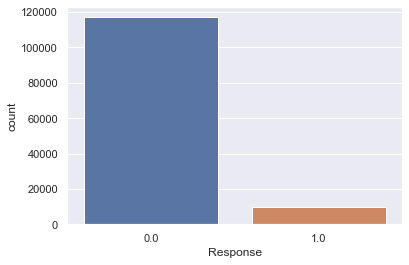

In [48]:
# Visualizing Predictor variable

sns.countplot(x= 'Response', data=dfTest)

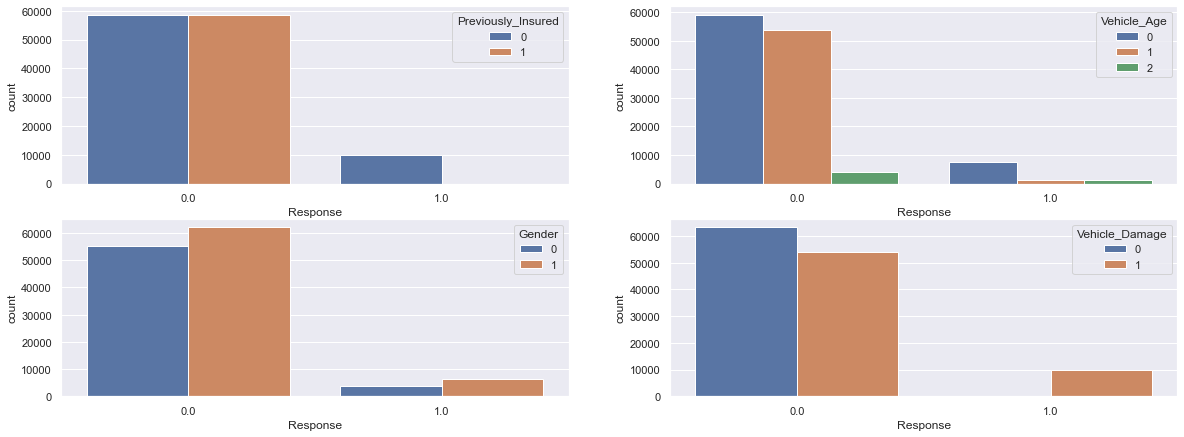

In [49]:
# Bivariate Analysis for categorical variables

plt.figure(figsize=(20,15))

for i, col in enumerate(cat_col):
    plt.subplot(4, 2, cat_col.index(col)+1)
    sns.countplot(x= 'Response', hue =col, data=dfTest)

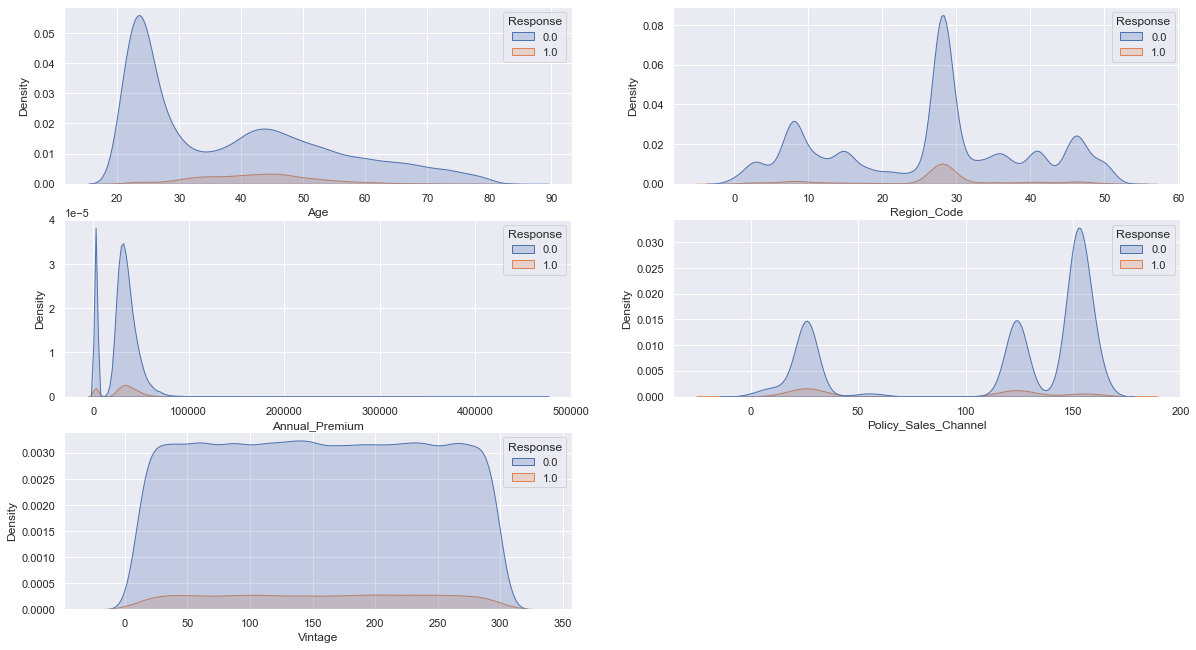

In [50]:
# Bivariate analysis for numerical variables

plt.figure(figsize=(20,15))

for i, col in enumerate(numeric_col):
    plt.subplot(4, 2, numeric_col.index(col)+1)
    sns.kdeplot(x= col, hue= 'Response', data=dfTest, fill=True)

## Conclusion

The Algorithm predicts the response on test set. We performed bivariate analysis on the predicted response and found that the algorithm targeted some participant groups for response 1:

(1) Previously insured
</br>
(2) Had vehicle damage

So, these are the participant groups the marketing team should put more focus on.